<a href="https://colab.research.google.com/github/kangmg/compchem_archive/blob/main/MLP/MLP_performance_near_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install requirement packages

!pip install -q git+https://github.com/cationic/torchani.git # torchani : ANI-1xnr model added version
!pip install -q git+https://github.com/kangmg/aimnet2ase.git # old version of aimnet2

# Diels Alder RXN IRC file
!wget -q https://raw.githubusercontent.com/kangmg/aimDIAS/main/examples/DA.xyz -O DA.xyz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 75.5 MB/s eta 0:00:00


In [10]:
#@title Check GPU

import torch

GPU_AVAILABLE = torch.cuda.is_available()

if GPU_AVAILABLE:
    print("\033[34mThe calculation will be performed using the GPU.\033[0m")
else:
    #print('There are no available GPU accelerators, so the calculations were done on the CPU, which took a long time.')
    print("\033[31mThere are no available GPU accelerators, so the calculations were done on the CPU, which took a long time.\033[0m")


The calculation will be performed using the GPU.


In [8]:
#@title Check OS enviroment & Install PySCF4ASE

INSTALLATION = """
=======================================================
Please install PySCF4ASE manually with pip.
-------------------------------------------------------

pip install git+https://github.com/kangmg/PySCF4ASE.git

# If you want to accelerate ab initio calculations using a GPU, install gpu4pyscf for your CUDA version.

pip install gpu4pyscf-cuda12x   # for CUDA version 12.x
pip install cutensor-cu12       # for CUDA version 12.x

                  OR

# pip install gpu4pyscf-cuda11x # for CUDA version 11.x
# pip install cutensor-cu11     # for CUDA version 11.x

-------------------------------------------------------
Refer)
    - https://github.com/kangmg/PySCF4ASE
    - https://github.com/pyscf/gpu4pyscf
=======================================================
"""

import platform

# install PySCF4ASE. Ref) https://github.com/kangmg/PySCF4ASE
if (platform.system() == "Linux"):
    if GPU_AVAILABLE:
        # install PySCF4ASE with GPU extension
        !wget -q https://raw.githubusercontent.com/kangmg/PySCF4ASE/main/setup.sh
        !chmod +x setup.sh
        !./setup.sh
    else:
        !pip install -q git+https://github.com/kangmg/PySCF4ASE.git

else:
    print(INSTALLATION)

PySCF4ASE Installation proceeding...

Cloning PySCF4ASE Repository...
Done!

Your CUDA Version: 12

Installing dependent packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.0/385.0 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Done!

Installation completed successfully.


In [11]:
#@title Custom Functions

from os.path import isfile
import re
from io import StringIO
import ase
import ase.io
from IPython.display import clear_output
import torchani
from tqdm.notebook import tqdm
from pyscf4ase.dft import PySCFCalculator

def read_traj(trajFile:str)->list[str]:
  """
  Description
  -----------
  Read trajectory data from a file in multiple XYZ format.

  Parameters
  ----------
  - trajFile : str
    The multiple xyz format trajectory file path to read.

  Returns
  -------
  - A list of xyz strings : list[str]
  """
  if isfile(trajFile):
    with open(trajFile, "r") as file:
      traj = file.read()
  else:
    raise FileNotFoundError(f"{traj} is not found.")

  # Split the trajectory file into multiple XYZ format strings
  pattern = re.compile("(\s?\d+\n.*\n(\s*[a-zA-Z]{1,2}(\s+-?\d+.\d+){3,3}\n?)+)")
  matched = pattern.findall(traj)

  xyzStringList = list(
      groups[0] for groups in matched
      )

  return xyzStringList


# dft calculator
def dft_get_energy(xyz_string:str, charge:None, kwargs):
  """
  Description
  -----------
  Calculate DFT energy

  Parameters
  ----------
  - xyz_string (str) : xyz format string
  - charge (int) : molecular total chage
  - basis (str) : basis set
  - functional (str) : functional
  - etc.

  Check `PySCFCalculator` docs string
  """
  # convert xyz format --> ase.Atoms
  mol = ase.io.read(StringIO(xyz_string), format="xyz")

  # set dft calculator
  mol.calc = PySCFCalculator(**kwargs)

  # get energy
  return mol.get_potential_energy()


# torchani calculator
def torchani_get_energy(xyz_string:str, charge:int, model:str, clear_log=True)->str:
  """
  Description
  -----------
  Calculate torchani energy

  Parameters
  ----------
  - xyz_string (str) : xyz format string
  - charge (int) : molecular total chage
  - model (str) : torchani ML potential model
  - clear_log (bool) : clear optimization logging

  Supported models
  ----------------
  - ani1ccx :  CCSD(T)*/CBS (DPLNO-CCSD(T)) | HCNO
  - ani1x   :  wB97X/6-31G(d)               | HCNO
  - ani2x   :  wB97X/6-31G(d)               | HCNOFSCl
  - ani1xnr   :  wB97X/6-31G(d)             | HCNO

  Returns
  -------
  - energy
  """
  # convert xyz format --> ase.Atoms
  mol = ase.io.read(StringIO(xyz_string), format="xyz")

  # check compatibility between the torchani model and the elements in the molecule
  model = model.lower()
  supporting_elements = {
      "ani1ccx" : {'H', 'C', 'N', 'O'},
      "ani1x"   : {'H', 'C', 'N', 'O'},
      "ani1xnr" : {'H', 'C', 'N', 'O'},
      "ani2x"   : {'H', 'C', 'N', 'O', 'F', 'S', 'Cl'}}

  elements_in_mol = set(mol.get_chemical_symbols())
  unsupported_elements = elements_in_mol - supporting_elements[model]
  if len(unsupported_elements) != 0:
    print(f"{unsupported_elements} are not compatible with the {model} model")
    return None

  # torchani supports only neutral compounds
  if charge != 0:
    print("torchani supports only neutral molecule")
    return None

  # set torchani calculator
  if model == "ani1ccx":
    mol.calc = torchani.models.ANI1ccx().ase()
  elif model == "ani1x":
    mol.calc = torchani.models.ANI1x().ase()
  elif model == "ani2x":
    mol.calc = torchani.models.ANI2x().ase()
  elif model == "ani1xnr":
    mol.calc = torchani.models.ANI1xnr().ase()
  else:
    raise ValueError("Not available model")

  # get energy

  return mol.get_potential_energy()



# aimnet2 calcalator
# Calculate aimnet2 energy
from aimnet2ase import aimnet2_get_energy



# traj energy calculation
def traj_calculator(xyz_list:str, charge:int, calc_ftn, calc_ftn_kwargs)->list:
  """
  Description
  -----------
  PES Scaner for multiple xyz format strings

  Parameters
  ----------
  - xyz_list (list) : xyz format string list
  - charge (int) : molecular total charge
  - calc_ftn (ftn) : calculator function

  Returns
  -------
  - energy_list (list) : energy list in eV
  """
  energy_list = []
  for xyz in tqdm(xyz_list):
    energy = calc_ftn(xyz_string=xyz, charge=charge, **calc_ftn_kwargs)
    energy_list.append(energy)

  return energy_list


# traj energy calculation
def traj_calculator(xyz_list:str, charge:int, calc_ftn, calc_ftn_kwargs)->list:
  """
  Description
  -----------
  traj 에너지 계산

  Parameters
  ----------
  - xyz_list (list) : xyz format string list
  - charge (int) : molecular total charge
  - calc_ftn (ftn) : calculator function

  Returns
  -------
  - energy_list (list) : energy list in eV
  """
  energy_list = []
  for xyz in tqdm(xyz_list):
    energy = calc_ftn(xyz_string=xyz, charge=charge, **calc_ftn_kwargs)
    energy_list.append(energy)

  return energy_list

def relative_energy(list):
  """adjust the energy list relative to the value at the zero index
  """
  return [x - list[0] for x in list]

/usr/local/lib/python3.10/dist-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


<font color=skyblue size=5>Split Diels Alder IRC file</font>

In [12]:
irc_points = read_traj('/content/DA.xyz')

# sampling 26 points
sampled_irc_points = irc_points[::4]

print(f"Original IRC points  : {len(irc_points)}")
print(f"Sampled  IRC points  : {len(sampled_irc_points)}")

Original IRC points  : 101
Sampled  IRC points  : 26


<font color=skyblue size=5>Calculations</font>

> AIMNet2

In [14]:
%%time

# aimnet2
aimnet2_b973c = traj_calculator(sampled_irc_points, 0, aimnet2_get_energy, {'model': 'b973c'})
aimnet2_wb97m_d3 = traj_calculator(sampled_irc_points, 0, aimnet2_get_energy, {'model': 'wb97m-d3'})

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

CPU times: user 40.1 s, sys: 783 ms, total: 40.9 s
Wall time: 43.2 s


> ANI

In [15]:
%%time
# torchani

print("ANI-1x")
ani1x = traj_calculator(sampled_irc_points, 0, torchani_get_energy, {'model': 'ani1x'})
clear_output()

print("ANI-2x")
ani2x = traj_calculator(sampled_irc_points, 0, torchani_get_energy, {'model': 'ani2x'})
clear_output()

print("ANI-1ccx")
ani1ccx = traj_calculator(sampled_irc_points, 0, torchani_get_energy, {'model': 'ani1ccx'})
clear_output()

# ani-1xnr is trained with periodic boundary conditions
print("ANI-1xnr")
ani1xnr = traj_calculator(sampled_irc_points, 0, torchani_get_energy, {'model': 'ani1xnr'})
clear_output()

print("ANI calculation done!")

ANI calculation done!
CPU times: user 3min 55s, sys: 3.17 s, total: 3min 58s
Wall time: 4min 11s


> DFT

In [ ]:
%%time
# dft calculation
# DFT calculation for 52 (26x2) points takes about 12,000 seconds with GPU acceleration.

# wb97m_d3 <-- aimnet2 target theory
dft_wb97m_d3bj = traj_calculator(sampled_irc_points, 0, dft_get_energy, {'kwargs': {'basis': 'def2-tzvpp', 'xc': 'wb97m-d3bj', 'nlc': 0, 'verbose': 0, 'charge': 0, 'spin': 0}})

# wb97x <-- torchani 1x, 2x target theory
dft_anix = traj_calculator(sampled_irc_points, 0, dft_get_energy, {'kwargs': {'basis': '6-31G(d)', 'xc': 'wB97X', 'nlc': 0, 'verbose': 0, 'charge': 0, 'spin': 0}})

<font color=skyblue size=5>Plot</font>

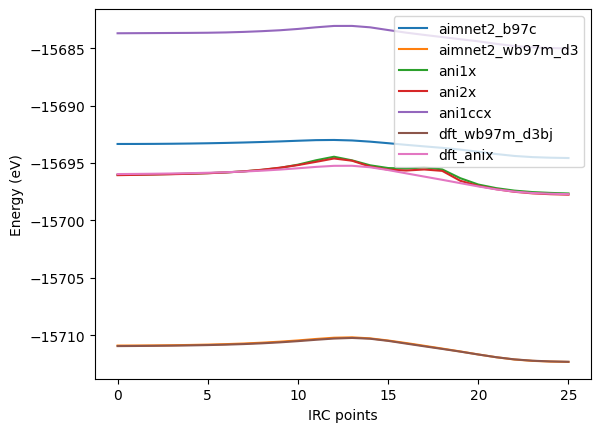

In [51]:
#@title Raw energies

import matplotlib.pyplot as plt

plt.plot(aimnet2_b973c, label='aimnet2_b97c')
plt.plot(aimnet2_wb97m_d3, label='aimnet2_wb97m_d3')
plt.plot(ani1x, label='ani1x')
plt.plot(ani2x, label='ani2x')
plt.plot(ani1ccx, label='ani1ccx')
plt.plot(dft_wb97m_d3bj, label='dft_wb97m_d3bj')
plt.plot(dft_anix, label='dft_anix')
#plt.plot(ani1xnr, label='ani1xnr')

plt.xlabel('IRC points')
plt.ylabel('Energy (eV)')
plt.legend()

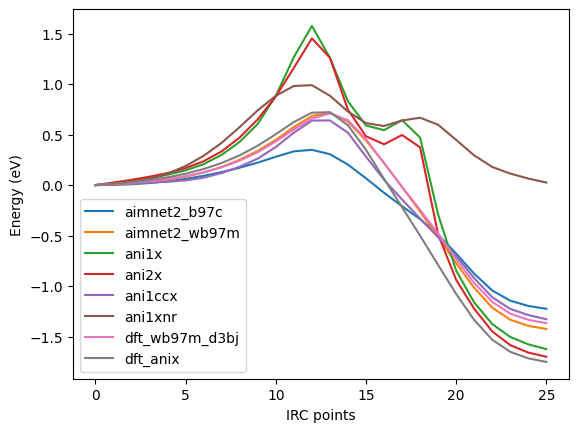

In [52]:
#@title Relative Energies

plt.plot(relative_energy(aimnet2_b973c), label='aimnet2_b97c')
plt.plot(relative_energy(aimnet2_wb97m_d3), label='aimnet2_wb97m')
plt.plot(relative_energy(ani1x), label='ani1x')
plt.plot(relative_energy(ani2x), label='ani2x')
plt.plot(relative_energy(ani1ccx), label='ani1ccx')
plt.plot(relative_energy(ani1xnr), label='ani1xnr')
plt.plot(relative_energy(dft_wb97m_d3bj), label='dft_wb97m_d3bj')
plt.plot(relative_energy(dft_anix), label='dft_anix')


plt.xlabel('IRC points')
plt.ylabel('Energy (eV)')
plt.legend()

In [53]:
# save result

import pandas as pd

summary_result = pd.DataFrame(
    {
        "xyz_string": sampled_irc_points,
        "aimnet2_b97c": aimnet2_b973c,
        "aimnet2_wb97m_d3": aimnet2_wb97m_d3,
        "ani1x": ani1x,
        "ani2x": ani2x,
        "ani1ccx": ani1ccx,
        "ani1xnr": ani1xnr,
        "dft_wb97m_d3bj": dft_wb97m_d3bj,
        "dft_anix": dft_anix,
    }
)

In [54]:
summary_result.to_csv('summary_result.csv')
summary_result.head()

,xyz_string,aimnet2_b97c,aimnet2_wb97m_d3,ani1x,ani2x,ani1ccx,ani1xnr,dft_wb97m_d3bj,dft_anix
0,26\n0 1 0.058933 \nC 0.9349010 0...,-15693.337066,-15710.897757,-15696.024213,-15696.053872,-15683.694237,-2916.683720,-15710.944007,-15695.957780
1,26\n0 1 0.059346 \nC 0.9417950 0...,-15693.335432,-15710.893095,-15696.005887,-15696.028303,-15683.685336,-2916.676365,-15710.933996,-15695.945195
2,26\n0 1 0.059803 \nC 0.9474770 0...,-15693.329076,-15710.883347,-15695.983821,-15696.001848,-15683.677272,-2916.659036,-15710.921786,-15695.929294
3,26\n0 1 0.060352 \nC 0.9523730 0...,-15693.316756,-15710.867569,-15695.955349,-15695.970750,-15683.669143,-2916.626116,-15710.905829,-15695.908296
4,26\n0 1 0.061080 \nC 0.9567290 0...,-15693.299259,-15710.845032,-15695.921453,-15695.934582,-15683.661260,-2916.571357,-15710.884455,-15695.880806
